In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

2024-07-17 19:18:02.408079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 19:18:02.408163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 19:18:02.409933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#paths to the clean images
clean_path = '/kaggle/input/salt-and-pepper-noise-images/Ground_truth'

In [3]:
def load_images_from_directory(directory, image_size=(350, 350)):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(image_size)
        img_array = np.array(img) / 255.0  # Normalize the images
        images.append(img_array)
    return np.array(images)

In [4]:
images= load_images_from_directory(clean_path)
images = np.expand_dims(images, axis=-1)

In [5]:
# Split into training and validation sets randomly (80-20 split)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=101)

In [6]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

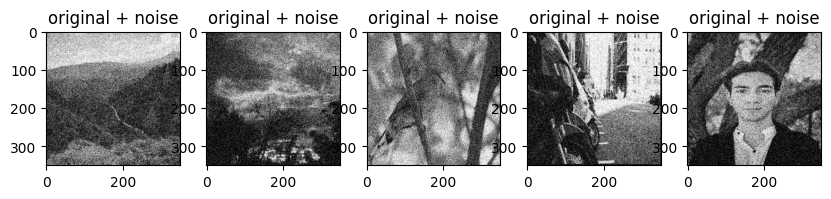

In [7]:
n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [8]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(360,350, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)
        ])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [9]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 360, 350, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 360, 350, 8)    │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - loss: 0.0693 - val_loss: 0.0675
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 0.0643 - val_loss: 0.0571
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 0.0531 - val_loss: 0.0417
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 0.0368 - val_loss: 0.0224
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 0.0188 - val_loss: 0.0146
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 0.0124 - val_loss: 0.0069
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 0.0068 - val_loss: 0.0061
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 0.0061 - val_loss: 0.0056
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 0.0057 - val_loss: 0.0049
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 0.0051 - val_loss: 0.0047


In [12]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 350, 350, 8)    │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 350, 350, 16)   │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 350, 350, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

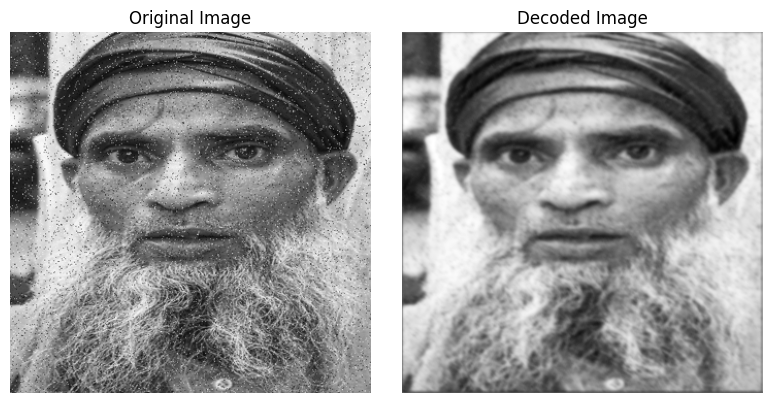

In [16]:
def load_and_preprocess_image(image_path, image_size=(350, 350)):
    img = Image.open(image_path).convert('L')  
    img = img.resize(image_size)
    img_array = np.array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array

# Example: Prompt user for an image file path
image_path = '/kaggle/input/salt-and-pepper-noise-images/Noisy_folder/noisy_6288026283_34c41df25c_c.jpg'

# Load and preprocess the user-provided image
input_image = load_and_preprocess_image(image_path)

# Encode and decode the image using the autoencoder
encoded_image = autoencoder.encoder(input_image).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()

# Display the original and decoded images (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np.squeeze(input_image))
plt.axis('off')

# Decoded image
plt.subplot(1, 2, 2)
plt.title('Decoded Image')
plt.imshow(np.squeeze(decoded_image))
plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

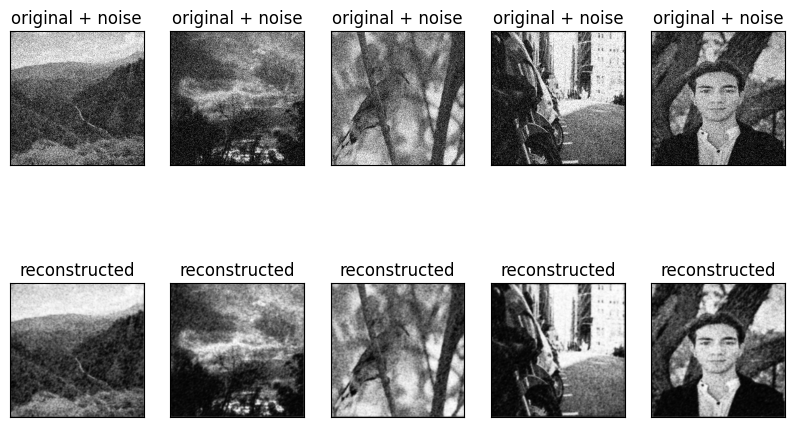

In [18]:
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()